In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = yf.download(tickers = '^NSEI ^SPX', start = '2010-01-01', end = dt.datetime.now(),interval = '1d', group_by = 'ticker',auto_adjust = True, treads = True)
raw_data.head()

[*********************100%***********************]  2 of 2 completed


^SPX                                                       \
                   Open         High          Low        Close        Volume   
Date                                                                           
2010-01-04  1116.560059  1133.869995  1116.560059  1132.989990  3.991400e+09   
2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020  2.491020e+09   
2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015  4.972660e+09   
2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941  5.270680e+09   
2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980  4.389590e+09   

                  ^NSEI                                                
                   Open         High          Low        Close Volume  
Date                                                                   
2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195    0.0  
2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902    0.0  
2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805    0.0  
2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098    0.0  
2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000    0.0

In [3]:
df = raw_data.copy()
df['nifty'] = raw_data['^NSEI'].Close[:]
df['spx'] = raw_data['^SPX'].Close[:]
del df['^NSEI']
del df['^SPX']
df['nifty'].fillna(method = 'ffill',inplace = True)
df['spx'].fillna(method = 'ffill',inplace = True)

<AxesSubplot:xlabel='Date'>

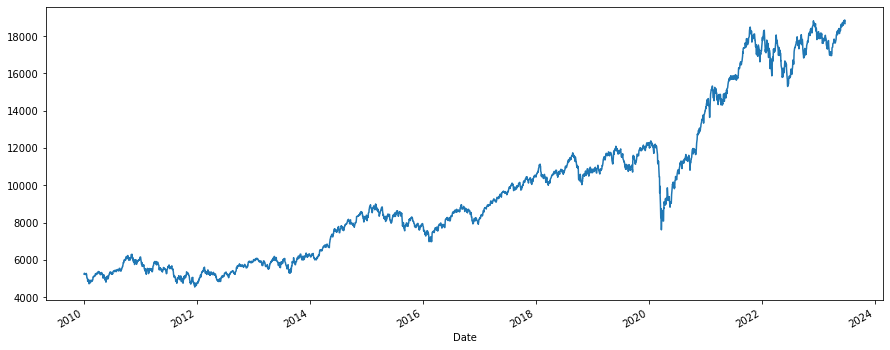

In [4]:
df['nifty'].plot(figsize = (15,6))

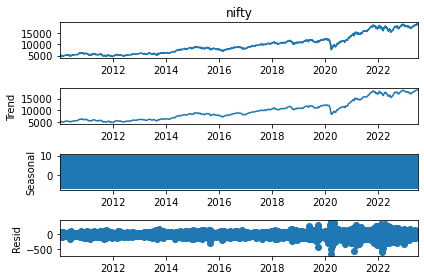

In [5]:
df.nifty.fillna(method = 'ffill',inplace = True)
s_dec_add = seasonal_decompose(df.nifty, model = 'additive',period = 7)
s_dec_add.plot();

In [6]:
df['Returns'] = df.nifty.pct_change(1)*100

Text(0.5, 1.0, 'Historical Returns')

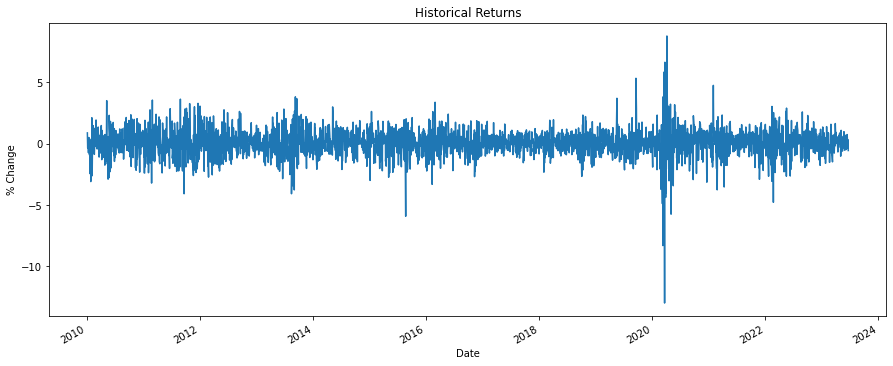

In [7]:
df['Returns'][1:].plot(figsize = (15,6))
plt.ylabel('% Change')
plt.title('Historical Returns')

In [8]:
def ADF_CHECK(time_series):
    result = adfuller(time_series)
    print('Augmented Dicky Fuller Test')
    labels = ["ADF Test statistic (T value to be compared with z values)", "p-value", "# of lags", "Num of observations used"]

    for output, label in zip(result, labels):
        print(label + ': ' + str(output))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("Reject null hypothesis")
        print("Data does not have a unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root and is non-stationary")


In [9]:
ADF_CHECK(df['nifty'])

Augmented Dicky Fuller Test
ADF Test statistic (T value to be compared with z values): 0.3260176243283672
p-value: 0.9785071720032755
# of lags: 9
Num of observations used: 3469
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


In [10]:
ADF_CHECK(df['Returns'][1:])

Augmented Dicky Fuller Test
ADF Test statistic (T value to be compared with z values): -18.909619103290296
p-value: 0.0
# of lags: 8
Num of observations used: 3469
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationary


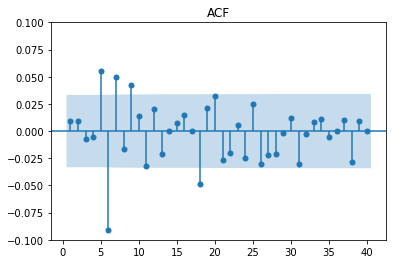

In [11]:
sgt.plot_acf(df["Returns"][1:],lags = 40,zero = False)
plt.title("ACF")
plt.ylim(-0.1,0.1)
plt.show()

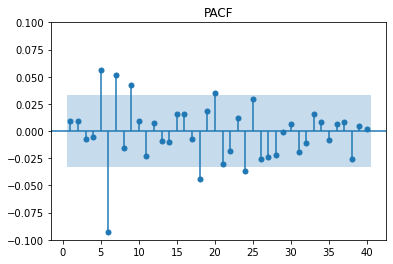

In [12]:
sgt.plot_pacf(df["Returns"][1:],lags = 40,zero = False)
plt.title("PACF")
plt.ylim(-0.1,0.1)
plt.show()

# AR MODEL

In [13]:
def LLR_TEST(mod_1,mod_2,DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = 2*(L2-L1)
    P = chi2.sf(LR,DF).round(3)
    return P

In [25]:
from statsmodels.tsa.arima.model import ARIMA

model_ar5 = ARIMA(df['Returns'][1:], order=(5, 0, 0)).fit()
model_ar6 = ARIMA(df['Returns'][1:], order=(6, 0, 0)).fit()
model_ar9 = ARIMA(df['Returns'][1:], order=(9, 0, 0)).fit()
print(model_ar9.summary())
print('\nLLR test P-value :' + str(LLR_TEST(model_ar6,model_ar9)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3478
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -5091.278
Date:                Fri, 23 Jun 2023   AIC                          10204.557
Time:                        19:18:01   BIC                          10272.253
Sample:                             0   HQIC                         10228.725
                               - 3478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0422      0.021      2.054      0.040       0.002       0.082
ar.L1          0.0214      0.012      1.736      0.083      -0.003       0.046
ar.L2          0.0024      0.010      0.233      0.8

In [26]:
df['res_ret'] = model_ar9.resid

In [27]:
print('Mean of residuals is:',df.res_ret.mean())
print('VOlatility of residuals is:',np.sqrt(df.res_ret.var()))
print(ADF_CHECK(df['res_ret'][1:]))


Mean of residuals is: -1.687252511543081e-05
VOlatility of residuals is: 1.0460761513128807
Augmented Dicky Fuller Test
ADF Test statistic (T value to be compared with z values): -58.975957209016315
p-value: 0.0
# of lags: 0
Num of observations used: 3477
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationary
None


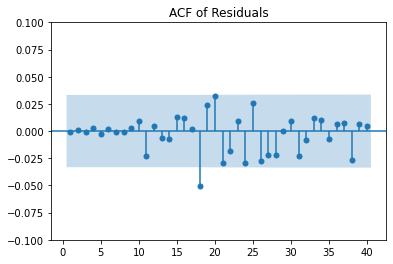

In [28]:
sgt.plot_acf(df['res_ret'][1:],lags = 40,zero = False)
plt.title("ACF of Residuals")
plt.ylim(-0.1,0.1)
plt.show()

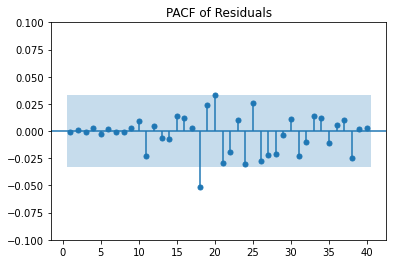

In [29]:
sgt.plot_pacf(df['res_ret'][1:],lags = 40,zero = False)
plt.title("PACF of Residuals")
plt.ylim(-0.1,0.1)
plt.show()

# MA MODEL

In [31]:
model_ma5 = ARIMA(df['Returns'][1:], order=(0, 0, 5)).fit()
model_ma6 = ARIMA(df['Returns'][1:], order=(0, 0, 6)).fit()
model_ma9 = ARIMA(df['Returns'][1:], order=(0, 0, 9)).fit()
print(model_ma9.summary())
print('\nLLR test P-value :' + str(LLR_TEST(model_ma6,model_ma9)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3478
Model:                 ARIMA(0, 0, 9)   Log Likelihood               -5092.739
Date:                Fri, 23 Jun 2023   AIC                          10207.477
Time:                        19:26:57   BIC                          10275.173
Sample:                             0   HQIC                         10231.645
                               - 3478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0422      0.020      2.062      0.039       0.002       0.082
ma.L1          0.0195      0.012      1.574      0.115      -0.005       0.044
ma.L2          0.0063      0.010      0.613      0.5

In [32]:
df['res_ret_ma'] = model_ma9.resid
print('Mean of residuals is:',df.res_ret.mean())
print('VOlatility of residuals is:',np.sqrt(df.res_ret.var()))
print(ADF_CHECK(df['res_ret'][1:]))

Mean of residuals is: -1.687252511543081e-05
VOlatility of residuals is: 1.0460761513128807
Augmented Dicky Fuller Test
ADF Test statistic (T value to be compared with z values): -58.975957209016315
p-value: 0.0
# of lags: 0
Num of observations used: 3477
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationary
None


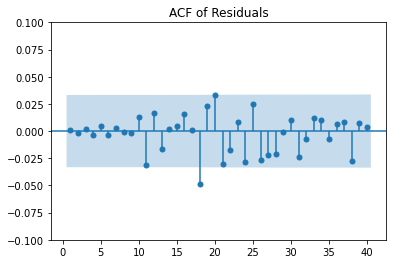

In [33]:
sgt.plot_acf(df['res_ret_ma'][1:],lags = 40,zero = False)
plt.title("ACF of Residuals")
plt.ylim(-0.1,0.1)
plt.show()

# ARMA

In [43]:
model_ar1_ma1 = ARIMA(df['Returns'][1:], order=(1, 0, 1)).fit()
model_ar6_ma5 = ARIMA(df['Returns'][1:], order=(6,0, 5)).fit()
model_ar5_ma4 = ARIMA(df['Returns'][1:], order=(5,0, 4)).fit()
model_ar4_ma5 = ARIMA(df['Returns'][1:], order=(4,0, 5)).fit()
model_ar5_ma6 = ARIMA(df['Returns'][1:], order=(5,0, 6)).fit()
print(model_ar5_ma6.summary())
print('\nLLR test P-value :' + str(LLR_TEST(model_ar5_ma4,model_ar5_ma6)))

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3478
Model:                 ARIMA(5, 0, 6)   Log Likelihood               -5088.247
Date:                Fri, 23 Jun 2023   AIC                          10202.493
Time:                        19:39:07   BIC                          10282.498
Sample:                             0   HQIC                         10231.055
                               - 3478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0422      0.019      2.185      0.029       0.004       0.080
ar.L1         -0.8213      0.212     -3.874      0.000      -1.237      -0.406
ar.L2         -0.5873      0.171     -3.436      0.0

In [44]:
print('LLR test P-value :' + str(LLR_TEST(model_ar4_ma5,model_ar5_ma6)))
print('\nLog likelihood of ARMA(5,0,6) is:' + str(model_ar5_ma6.llf))
print('\nLog likelihood of ARMA(6,0,5) is:' + str(model_ar6_ma5.llf))

LLR test P-value :0.004

Log likelihood of ARMA(5,0,6) is:-5088.246615169749

Log likelihood of ARMA(6,0,5) is:-5087.89324640091


In [45]:
df['res_ret_ar_ma'] = model_ar6_ma5.resid
print('Mean of residuals is:',df.res_ret_ar_ma.mean())
print('VOlatility of residuals is:',np.sqrt(df.res_ret_ar_ma.var()))
print(ADF_CHECK(df['res_ret_ar_ma'][1:]))

Mean of residuals is: -3.725853452418842e-05
VOlatility of residuals is: 1.0450593462269482
Augmented Dicky Fuller Test
ADF Test statistic (T value to be compared with z values): -59.25744365902688
p-value: 0.0
# of lags: 0
Num of observations used: 3477
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationary
None


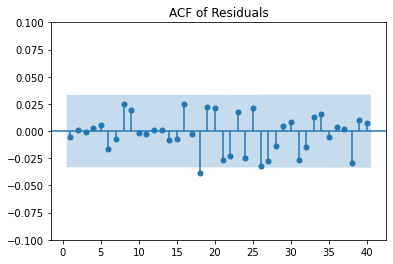

In [46]:
sgt.plot_acf(df['res_ret_ar_ma'][1:],lags = 40,zero = False)
plt.title("ACF of Residuals")
plt.ylim(-0.1,0.1)
plt.show()

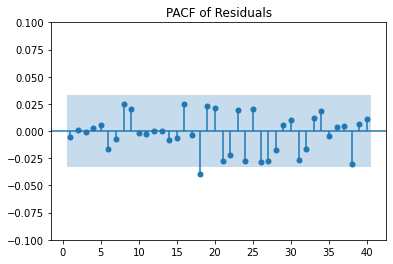

In [47]:
sgt.plot_pacf(df['res_ret_ar_ma'][1:],lags = 40,zero = False)
plt.title("PACF of Residuals")
plt.ylim(-0.1,0.1)
plt.show()

# ARIMA MODEL 

In [49]:
df['First Difference'] = df['nifty']-df['nifty'].shift(1)
df['First Difference'].fillna(0,inplace = True)
df.head()

,nifty,spx,Returns,res_ret,res_ret_ma,res_ret_ar_ma,First Difference
,,,,,,,
Date,,,,,,,
2010-01-04,5232.200195,1132.989990,NaN,NaN,NaN,NaN,0.000000
2010-01-05,5277.899902,1136.520020,0.873432,0.831268,0.831269,0.831239,45.699707
2010-01-06,5281.799805,1137.140015,0.073891,0.023630,0.023788,0.019158,3.899902
2010-01-07,5263.100098,1141.689941,-0.354040,-0.403991,-0.406159,-0.403653,-18.699707
2010-01-08,5244.750000,1144.979980,-0.348656,-0.381109,-0.378600,-0.380156,-18.350098


In [50]:
ADF_CHECK(df['First Difference'])

Augmented Dicky Fuller Test
ADF Test statistic (T value to be compared with z values): -18.76985057848083
p-value: 2.0253282162003623e-30
# of lags: 8
Num of observations used: 3470
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationary


In [58]:
model_ar2_i1_ma3 = ARIMA(df['nifty'],order = (2,1,3)).fit()
model_ar4_i1_ma3 = ARIMA(df['nifty'],order = (4,1,3)).fit()
model_ar3_i1_ma3 = ARIMA(df['nifty'],order = (3,1,3)).fit()
model_ar3_i1_ma4 = ARIMA(df['nifty'],order = (3,1,4)).fit()

model_ar3_i1_ma4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  nifty   No. Observations:                 3479
Model:                 ARIMA(3, 1, 4)   Log Likelihood              -21068.697
Date:                Fri, 23 Jun 2023   AIC                          42153.394
Time:                        19:43:32   BIC                          42202.627
Sample:                             0   HQIC                         42170.970
                               - 3479                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2370      0.045    -27.269      0.000      -1.326      -1.148
ar.L2         -1.1621      0.055    -21.070      0.000      -1.270      -1.054
ar.L3         -0.7791      0.049    -15.811      0.000      -0.876      -0.683
ma.L1          1.2614      0.047     26.968      0.000       1.170       1.353
ma.L2          1.1741      0.060     19.468      0.000       1.056       1.292
ma.L3          0.7621      0.055     13.948      0.000       0.655       0.869
ma.L4         -0.0399      0.011     -3.538      0.000      -0.062      -0.018
sigma2      1.074e+04    109.510     98.037      0.000    1.05e+04     1.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             19411.87
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               6.55   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
print(LLR_TEST(model_ar2_i1_ma3,model_ar3_i1_ma3))
print(LLR_TEST(model_ar3_i1_ma3,model_ar3_i1_ma4))
print('ARIMA(2,1,3):'+ '\t Log likelihood is: ' + str(model_ar2_i1_ma3.llf) + '\t AIC is: ' + str(model_ar2_i1_ma3.aic))
print('ARIMA(3,1,3):'+ '\t Log likelihood is: ' + str(model_ar3_i1_ma3.llf) + '\t AIC is: ' + str(model_ar3_i1_ma3.aic))
print('ARIMA(3,1,4):'+ '\t Log likelihood is: ' + str(model_ar3_i1_ma4.llf) + '\t AIC is: ' + str(model_ar3_i1_ma4.aic))
print('ARIMA(4,1,3):'+ '\t Log likelihood is: ' + str(model_ar4_i1_ma3.llf) + '\t AIC is: ' + str(model_ar4_i1_ma3.aic))


0.017
0.035
ARIMA(2,1,3):	 Log likelihood is: -21073.78464379388	 AIC is: 42159.56928758776
ARIMA(3,1,3):	 Log likelihood is: -21070.916523171407	 AIC is: 42155.833046342814
ARIMA(3,1,4):	 Log likelihood is: -21068.69688220226	 AIC is: 42153.39376440452
ARIMA(4,1,3):	 Log likelihood is: -21068.870602648138	 AIC is: 42153.741205296275


In [60]:
df['res_ret_ar_i_ma'] = model_ar3_i1_ma4.resid
print('Mean of residuals is:',df.res_ret_ar_i_ma.mean())
print('Volatility of residuals is:',np.sqrt(df.res_ret_ar_i_ma.var()))
print(ADF_CHECK(df['res_ret_ar_i_ma']))

Mean of residuals is: 5.3825390743405
Volatility of residuals is: 136.15016978746624
Augmented Dicky Fuller Test
ADF Test statistic (T value to be compared with z values): -17.463154187276036
p-value: 4.585475764283136e-30
# of lags: 10
Num of observations used: 3468
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationary
None


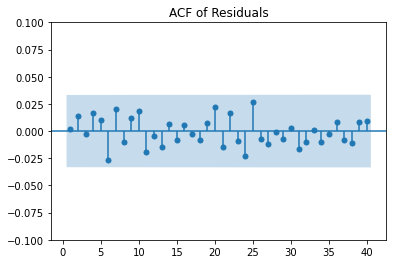

In [61]:
sgt.plot_acf(df['res_ret_ar_i_ma'],lags = 40,zero = False)
plt.title("ACF of Residuals")
plt.ylim(-0.1,0.1)
plt.show()

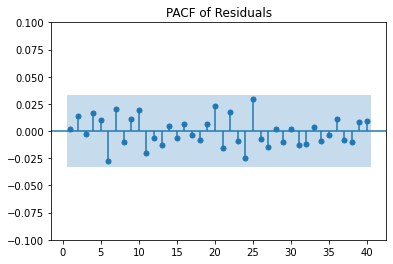

In [62]:
sgt.plot_pacf(df['res_ret_ar_i_ma'],lags = 40,zero = False)
plt.title("PACF of Residuals")
plt.ylim(-0.1,0.1)
plt.show()

# ARIMAX

In [63]:
model_arimax111 = ARIMA(df['nifty'],order = (1,1,1),exog = df['spx']).fit()

model_arimax111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  nifty   No. Observations:                 3479
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20949.616
Date:                Fri, 23 Jun 2023   AIC                          41907.231
Time:                        19:44:44   BIC                          41931.848
Sample:                             0   HQIC                         41916.020
                               - 3479                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            0.9918      0.028     34.945      0.000       0.936       1.047
ar.L1          0.3476      0.120      2.903      0.004       0.113       0.582
ma.L1         -0.4043      0.117     -3.445      0.001      -0.634      -0.174
sigma2      9996.3566    108.389     92.227      0.000    9783.918    1.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14656.04
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.49   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SARIMAX

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [65]:
model_sarimax = SARIMAX(df['nifty'][2500:],order = (1,1,1),exog = df['spx'][2500:],seasonal_order = (2,1,1,5)).fit()

In [66]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             nifty   No. Observations:                  979
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 5)   Log Likelihood               -6303.442
Date:                           Fri, 23 Jun 2023   AIC                          12620.885
Time:                                   19:45:04   BIC                          12655.047
Sample:                                        0   HQIC                         12633.886
                                           - 979                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            0.9211      0.072     12.858      0.000       0.781       1.061
ar.L1         -0.9618      0.048    -19.961      0.000      -1.056      -0.867
ma.L1          0.9731      0.040     24.111      0.000       0.894       1.052
ar.S.L5        0.0921      0.030      3.052      0.002       0.033       0.151
ar.S.L10      -0.0328      0.029     -1.143      0.253      -0.089       0.023
ma.S.L5       -1.0000      6.020     -0.166      0.868     -12.798      10.798
sigma2      2.393e+04   1.44e+05      0.166      0.868   -2.58e+05    3.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.26   Jarque-Bera (JB):               652.53
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.66
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.05e+14. Standard errors may be unstable.
"""

In [85]:
print('AR(9):'+ '\t\t\t\t Log likelihood is: ' + str(model_ar9.llf) + '\t AIC is: ' + str(model_ar9.aic))
print('MA(9):'+ '\t\t\t\t Log likelihood is: ' + str(model_ma9.llf) + '\t AIC is: ' + str(model_ma9.aic))
print('ARMA(6,5):'+ '\t\t\t Log likelihood is: ' + str(model_ar6_ma5.llf) + '\t AIC is: ' + str(model_ar6_ma5.aic))
print('ARIMA(3,1,4):'+ '\t\t\t Log likelihood is: ' + str(model_ar3_i1_ma4.llf) + '\t AIC is: ' + str(model_ar3_i1_ma4.aic))
print('ARIMAX(1,1,1):'+ '\t\t\t Log likelihood is: ' + str(model_arimax111.llf) + '\t AIC is: ' + str(model_arimax111.aic))
print('SARIMAX(1,1,1)(2,1,1,5):'+ '\t Log likelihood is: ' + str(model_sarimax.llf) + '\t AIC is: ' + str(model_sarimax.aic))



AR(9):				 Log likelihood is: -5091.278497118973	 AIC is: 10204.556994237946
MA(9):				 Log likelihood is: -5092.738528744247	 AIC is: 10207.477057488493
ARMA(6,5):			 Log likelihood is: -5087.89324640091	 AIC is: 10201.78649280182
ARIMA(3,1,4):			 Log likelihood is: -21068.69688220226	 AIC is: 42153.39376440452
ARIMAX(1,1,1):			 Log likelihood is: -20949.61567109193	 AIC is: 41907.23134218386
SARIMAX(1,1,1)(2,1,1,5):	 Log likelihood is: -6303.442299574484	 AIC is: 12620.884599148969
